In [ ]:
Group: Bohdan Babii, Felix Kreß

# Exercise 4 - Spam Filtering with Naive Bayes

In this Exercise we will implement a spam detector that relies on the naive Bayes assumption. We will then compare its performance to logistic regression.

In the event of a persistent problem, do not hesitate to contact the course instructors under

- paul.kahlmeyer@uni-jena.de
- maurice.wenig@uni-jena.de

### Submission
- Deadline of submission:
14.05.2024 23:59
- Submission on [moodle page](https://moodle.uni-jena.de/course/view.php?id=54249)

# Dataset

We will use the [SMS Spam Collection Dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset?resource=download). You find this dataset as `spam_data.csv`. Each line consists of a message together with a label:
- spam (message is a spam message)
- ham (message is legitimate)

### Task 1
Find a way to load the dataset and transform the features `X` (SMS) and the labels `Y` (spam/ham) into numerical representations.

For transforming SMS into features, check out the bag of words representation from [scikit-learn](https://scikit-learn.org/stable/modules/feature_extraction.html)

In [38]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# TODO: load data, transform into numerical features + labels


df = pd.read_csv('spam_data.csv', names=['labels', 'messages'], header=None, skiprows=1)


vectorizer = CountVectorizer()

# Transform messages into a bag-of-words representation
x = vectorizer.fit_transform(df['messages']).toarray()

# Transform labels into numerical values
y = np.where(df['labels'] == 'ham', 0, 1)  # Encode 'ham' as 0 and 'spam' as 1

# assertions
assert x.shape == (5573, 8798)
assert y.shape == (5573,)
assert np.sum(x) == 80997

# Naive Bayes

The naive Bayes filter is based on the Bayes formula with an additional simplifying (naive) assumption about the nature of the likelihood.

Let $S = \{\text{spam}, \text{ham}\}$ be the source of a SMS and $W = [w_1,\dots w_k]$ be the sequence of words contained in the SMS.
Then filtering for spam and ham is done by evaluating the posterior distribution
\begin{align}
p(S|W)&=\cfrac{p(S)p(W|S)}{p(W)}
\end{align}

Lets look at the single parts of the equations right hand side and how to implement them.

As a running example we will use $W = [\text{this}, \text{is}, \text{no}, \text{spam}, \text{message}]$.

## Prior $p(S)$

The prior distribution $p(S)$ is independent of the message $W$. We will use the maximum likelihood (ML) estimate for a categorical distribution, which is the relative frequency of the categories among the dataset.
\begin{align}
p(S = \text{spam})_{ML} &= \cfrac{\text{\# SMS that are spam}}{\text{\# SMS}}\\
p(S = \text{ham})_{ML} &= 1 - p(S = \text{spam})
\end{align}

### Task 2

Estimate $p(S)$. Display the estimated distribution in a bar chart.

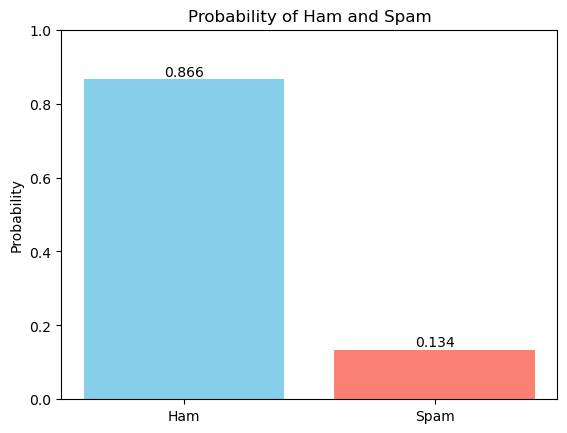

In [39]:
import matplotlib.pyplot as plt

# TODO: estimate p(S), display in bar chart
p_spam = np.mean(y)
p_ham = 1 - p_spam

# assertions
assert np.isclose(p_spam, 0.13403911717207967)


# Creating the plot
labels = ['Ham', 'Spam']
values = [p_ham, p_spam]

fig, ax = plt.subplots()
bars = ax.bar(labels, values, color=['skyblue', 'salmon'])

# Adding value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

# Adding titles and labels
ax.set_ylabel('Probability')
ax.set_title('Probability of Ham and Spam')
plt.ylim(0, 1)  # Set y-axis limits to show probabilities clearly from 0 to 1
plt.show()

## Likelihood p(W|S)

The likelihood distribution models how likely a SMS is, given we know its either spam or ham.

E.g. for $W = [\text{this}, \text{is}, \text{no}, \text{spam}, \text{message}]$ we would expect something like 
\begin{align}
p(W|S=\text{spam}) &= \text{low}\\
p(W|S=\text{ham}) &= \text{medium}\\
\end{align}

However to estimate $p(W|S)$ we would need a dataset with the exact same $W$ appearing in both contexts: spam and ham. Since this is not the case for our dataset, this is the part where we make a naive assumption:
\begin{align}
p(W|S) = \prod_{w\in W}p(w|S)
\end{align}
That is, we consider each word in the SMS text independend of the others. This simplification enables us to estimate the likelihood, since single words to in fact appear in both contexts.

For a single word $w$, we can again estimate the probability as relative frequency 
\begin{align}
p(w|S = \text{spam})_{ML} &= \cfrac{\text{\# word $w$ is labeled spam}}{\text{\# any word is labeled spam}}\\
p(w|S = \text{ham})_{ML} &= \cfrac{\text{\# word $w$ is labeled ham}}{\text{\# any word is labeled ham}}\\
\end{align}

Since we cannot expect every word to have appeared in a spam and ham message, we will smooth our dataset with a [Laplace smoothing](https://en.wikipedia.org/wiki/Additive_smoothing) of $\varepsilon = 0.001$. 

This is done by adding $\varepsilon$ to the count of every word in every SMS.

As an example the count vector for a SMS over a vocabulary of 5 words is transformed from
\begin{align}
[1, 2, 0, 0, 1]
\end{align}
into
\begin{align}
[1.001, 2.001, 0.001, 0.001, 1.001]\,.
\end{align}

This way we do not have zero probabilities in the product for calculating $p(W|S)$.

### Task 3

Apply Laplace smoothing ($\varepsilon = 0.001$) to the dataset.

In [40]:
# TODO: apply Laplace smoothing
x_smooth = x + 0.001

# assertions
assert np.isclose(np.sum(x_smooth), 80997 + 5573 * 8798 * 0.001)

### Task 4

For $W = [\text{this}, \text{is}, \text{no}, \text{spam}, \text{message}]$, calculate $p(W|S)$.

Display $p(w|S = \text{spam}), p(w|S = \text{ham})$ for every $w\in W$.

[7727, 4234, 5403, 7162, 5026]


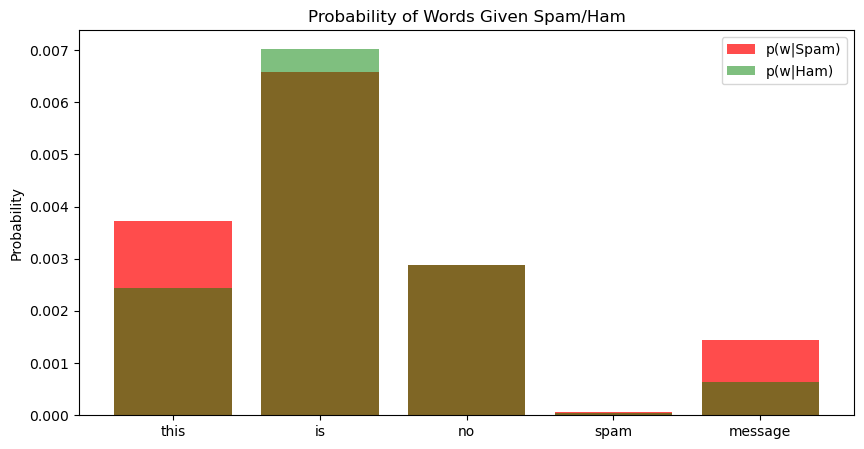

In [68]:
# TODO: calculate p(W|S) for W = [this is no spam message]
vectorizer = CountVectorizer()
vectorizer.fit(df['messages'])
vocab = vectorizer.vocabulary_

test_message = ["this", "is", "no", "spam", "message"]
indices = [vocab[word] for word in test_message if word in vocab]

spam_mask = y == 1
spam_words = x_smooth[spam_mask].sum(axis=0)
ham_words = x_smooth[~spam_mask].sum(axis=0)
total_spam_words = spam_words.sum()
total_ham_words = ham_words.sum()

p_w_given_spam = [spam_words[idx] / total_spam_words for idx in indices]
p_w_given_ham = [ham_words[idx] / total_ham_words for idx in indices]

p_test_message_given_spam = np.prod(p_w_given_spam)
p_test_message_given_ham = np.prod(p_w_given_ham)

# assertions
assert np.isclose(p_test_message_given_spam, 7.31708303756972e-15)
assert np.isclose(p_test_message_given_ham, 1.4235772856358894e-15)

# TODO: plot p(w|S)
plt.figure(figsize=(10, 5))
plt.bar(test_message, p_w_given_spam, color='red', alpha=0.7, label='p(w|Spam)')
plt.bar(test_message, p_w_given_ham, color='green', alpha=0.5, label='p(w|Ham)')
plt.ylabel('Probability')
plt.title('Probability of Words Given Spam/Ham')
plt.legend()
plt.show()

### Task 5
From the dataset, list the top 5 words with the highest probabilities $p(w|S = \text{spam})$ and $p(w|S = \text{ham})$.

In [67]:
# TODO: list top 5 words accoding to p(w|S)
inverse_vocab = {}
for word, index in vocab.items():
    inverse_vocab[index] = word

top_spam_indices = np.argsort(p_w_given_spam)[::-1]
top_ham_indices = np.argsort(p_w_given_ham)[::-1]

top_spam_words = [inverse_vocab[i] for i in top_spam_indices[:5]]
top_ham_words = [inverse_vocab[i] for i in top_ham_indices[:5]]

# assertions
assert set(top_spam_words) == {"to", "call", "you", "your", "free"}
assert set(top_ham_words) == {"you", "to", "the", "and", "in"}

## Evidence $p(W)$

The evidence tells us how likely the SMS was anyway. In many cases this is the most difficult part of the posterior to calculate. Here however we are lucky, since there are only two cases for $S$ and therefore
\begin{align}
p(W) = p(W|S=\text{spam}) + p(W|S=\text{ham})
\end{align}

That is $p(W)$ acts as a normalization constant.

### Task 6

For $W = [\text{this}, \text{is}, \text{no}, \text{spam}, \text{message}]$, calculate $p(W)$.

In [70]:
# TODO: calculate p(W) for W = [this is no spam message]
p_test_message = p_test_message_given_spam * p_spam + p_test_message_given_ham * p_ham
assert np.isclose(p_test_message, 8.740660323205609e-15)

## Classification

With Prior, Likelihood and Evidence we can now assemble the Posterior
\begin{align}
p(S|W)&=\cfrac{p(S)p(W|S)}{p(W)}\,.
\end{align}

Remember that we want to use the Posterior to classify $W$:
\begin{align}
\kappa(W) = \begin{cases}
\text{spam}&\text{, if }p(S = \text{spam}|W) \geq p(S = \text{ham}|W)\\
\text{ham}&\text{, else}
\end{cases}
\end{align}

### Task 7

Implement the following `NaiveBayes` class. 

Use it to fit and predict on the dataset.

In [82]:
import numpy.typing as npt
from typing import Self


class NaiveBayesClassifier():
    def __init__(self, laplace_smoothing_constant: float = 0.0001):
        """Class for binary naive Bayes."""

        self.laplace_regularization_constant = laplace_smoothing_constant
        # n_labels x n_words
        self.log_p_word_given_label: npt.NDArray[np.float64] = None
        # n_labels
        self.log_p_label: npt.NDArray[np.float64] = None

    def fit(self, x: npt.NDArray[np.float64], y: npt.NDArray[np.bool_]) -> Self:
        """Given a dataset of count vectors, calculates probabilities needed for prediction.

        Parameters
        ----------
        x : npt.NDArray[np.float64]
            Word count matrix (n_sms x n_words).
        y : npt.NDArray[np.bool_]
            Label matrix (n_sms).
        """

        # TODO: implement
        return self

    def predict(self, x: npt.NDArray[np.float64]) -> npt.NDArray[np.bool_]:
        """Given a dataset of count vectors, predicts labels.

        Parameters
        ----------
        x : npt.NDArray[np.float64]
            Word count matrix (n_sms x n_words).

        Returns
        -------
        npt.NDArray[np.bool_]
            Vector of predictions for labels (0 = ham, 1 = spam).
        """

        # TODO: implement
        pass

    def accuracy(self, x: npt.NDArray[np.float64], y: npt.NDArray[np.bool_]) -> float:
        """Calculates accuracy for given dataset.

        Parameters
        ----------
        x : npt.NDArray[np.float64]
            Word count matrix (n_sms x n_words).
        y : npt.NDArray[np.bool_]
            Vector of true labels (0 = ham, 1 = spam).

        Returns
        -------
        float
            Percentage of correctly classified x.
        """

        # TODO: implement
        pass


# assertions
classifier = NaiveBayesClassifier(laplace_smoothing_constant=0.0001).fit(x, y)
assert classifier.accuracy(x, y) > 0.99

TypeError: '>' not supported between instances of 'NoneType' and 'float'

### Task 8

Obviously we trained on the same dataset as we tested and therefore cannot quite judge the performance of the naive Bayes classifier. 

Split your data into 75% training- and 25% testdata. Use a seed for reproducibility.

In [ ]:
# TODO: provide train + testsplit
x_train, x_test, y_train, y_test = None
assert np.isclose(len(x_train) / len(x_test), 3, atol=0.01)

### Task 9

Now we systematically want to test our classifier. 

For different values of $\varepsilon$ track the accuracy on train and testdata.
Which value for $\varepsilon$ would you recommend?

In [ ]:
# TODO: report train- and test accuracy for different epsilons